In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
import networkx as nx
import torch
from torch_geometric.utils import *
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Not found')
print('Found GPU at: {}'.format(device_name))

Not found
Found GPU at: 


In [47]:
P = np.zeros((3,3))

In [48]:
P

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [49]:
P[0,0] = 0.8
P[0,1] = 0.2
P[0,2] = 0.3
P[1,1] = 0.7
P[1,2] = 0.4
P[2,2] = 0.6
P = P + P.T - np.diag(P.diagonal())

In [50]:
k = 0
K = 3
n = 33

In [51]:
def make_basis(P,K):
    basis = []
    for i in range(K):
        basis.append([])
        for j in range(i,K):
            alpha = 0
            alpha = np.arccos(P[i,j])
            if i == j:## COLOCA OS DOIS VETORES PARA FORMAR A BASE
                v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                basis[-1].append([])
                basis[-1][-1].append(v)
                v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[-1][-1].append(v)
            else:## ESCOLHE ALEATORIAMENTE UM DOS VETORES
                u = np.random.uniform(0,1)
                v = np.zeros(2)
                if u > 0.5:
                    v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                else:
                    v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[-1].append(v)
    return basis

In [52]:
def make_vectors(basis,K,n,delta):
    X = np.zeros((3*n,2*K))
    for c in range(K):
        for i in range(n):
            for j in range(K):
                r = np.random.uniform(1,delta)
                if j<k:
                    X[i+n*c][2*j:2*j+2] = r*np.flip(basis[k][j])
                elif j==k:
                    u = np.random.uniform(0,1)
                    v = np.zeros(2)
                    if u > 0.5:
                        v = r*basis[k][j][1]
                    else:
                        v = r*basis[k][j][0]
                    X[i+n*c][2*j:2*j+2] = v
                else:
                    X[i+n*c][2*j:2*j+2] = r*basis[k][j]
    return X

In [53]:
basis = make_basis(P,K)
delta=2
X = make_vectors(basis,K,n,delta)

## Traditional Neural Networks Embedding

In [54]:
def get_Autoencoder(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2,activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(input_shape,activation='relu'))
#     model.summary()
    model.compile(optimizer=opt,loss='MSE')
    return model

In [55]:
def get_ANN(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2,activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3,activation='softmax'))
#     model.summary()
    model.compile(optimizer=opt,loss='CategoricalCrossentropy')
    return model

In [56]:
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
    name='NAdam'
)

In [57]:
def getExtractionModel(up_to=1,model=None):
    extractor = Sequential()
    for i in range(up_to):
        extractor.add(model.layers[i])
    return extractor

In [58]:
y = np.hstack([np.ones(n,dtype=np.int16)*i for i in range(K)])
Y = np.zeros((y.size, y.max()+1))
Y[np.arange(y.size),y] = 1

In [59]:
def NN_embedding(X,Y,autoencoder=False):
    model= None
    if autoencoder:
        model = get_Autoencoder((X.shape[1]))
        model.fit(X,X,epochs=100,shuffle=True,verbose=0)
    else:
        model = get_ANN((X.shape[1]))
        model.fit(X,Y,epochs=100,shuffle=True,verbose=0)
    encode = getExtractionModel(up_to=2,model=model)
#     print(encode.summary())
    X_t = np.array(encode.predict(X))
    return X_t

In [60]:
X.dtype

dtype('float64')

## Graph Neural Networks Embedding

In [61]:
def make_graph_data(X):
    G = nx.stochastic_block_model([n]*K,P,seed=42)
    for i in range(n*K):
        G.nodes[i]["attr"] = X[i,:]
    graph_data = from_networkx(G,group_node_attrs=['attr'])
    return graph_data

In [62]:
class GCN(torch.nn.Module):
    def __init__(self,n_feat):
        super().__init__()
        self.conv1 = GCNConv(n_feat, 2)
#         self.conv2 = GCNConv(16,2)
        self.mlp = torch.nn.Linear(2,K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
        x = self.mlp(x)
        return F.log_softmax(x, dim=1)

In [63]:
P

array([[0.8, 0.2, 0.3],
       [0.2, 0.7, 0.4],
       [0.3, 0.4, 0.6]])

In [64]:
def train_model(model,graph_data,Y,epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = total = 0
    graph_data.x = Tensor.float(graph_data.x)
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    target = Tensor(Y)
    while total < epochs:
        optimizer.zero_grad()
        out = model(graph_data)
        loss = loss_fn(out,target)
        loss.backward()
        optimizer.step()
        total += 1

In [65]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [66]:
def make_GNN_embedding(X,Y):
    graph_data = make_graph_data(X)
    model = GCN(graph_data.num_node_features)
    train_model(model,graph_data,Y)
    model.conv1.register_forward_hook(get_activation('conv1'))
    out = model(graph_data)
    X_t = F.relu(activation["conv1"]).detach().numpy()
    return X_t

In [67]:
def make_plot(X,title,delta):
    plt.scatter(X_t[:n,0],X_t[:n,1],label="1")
    plt.scatter(X_t[n:2*n,0],X_t[n:2*n,1],label="2")
    plt.scatter(X_t[2*n:3*n,0],X_t[2*n:3*n,1],label="3")
    plt.legend()
    plt.title(title)
    plt.savefig("embedding_"+title+f"$\delta$_{delta}.png")
    plt.show()

---------------- Delta = 1.0 -------------------


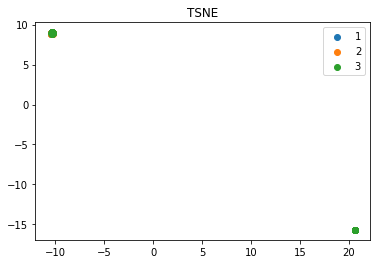

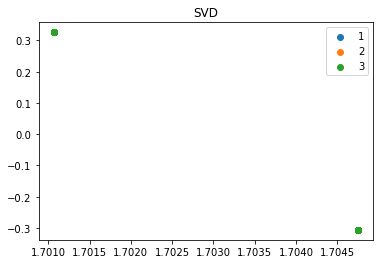

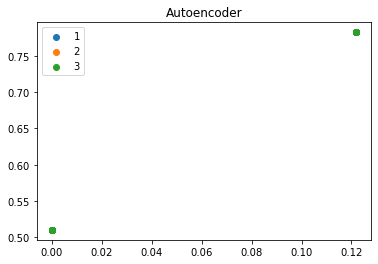

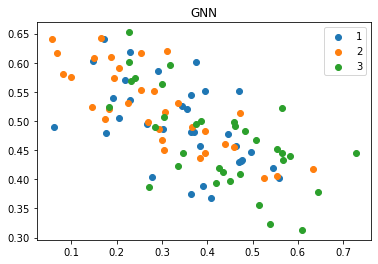

---------------- Delta = 3.25 -------------------


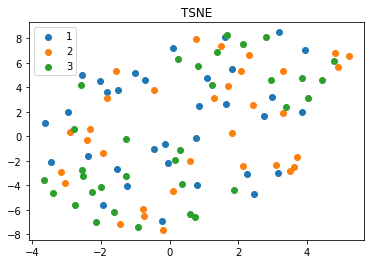

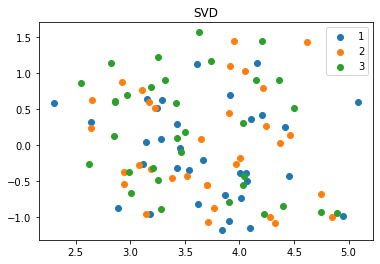

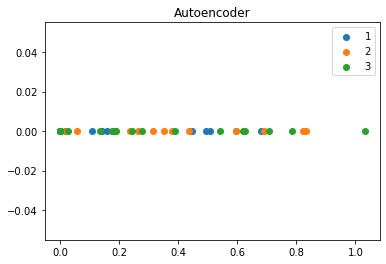

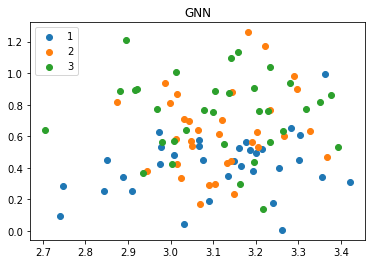

---------------- Delta = 5.5 -------------------


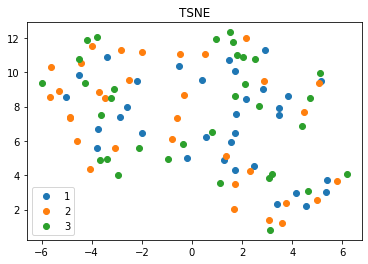

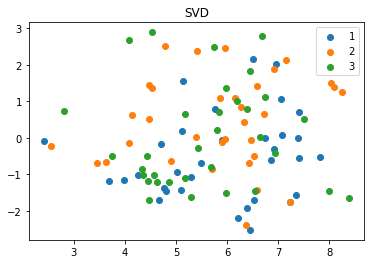

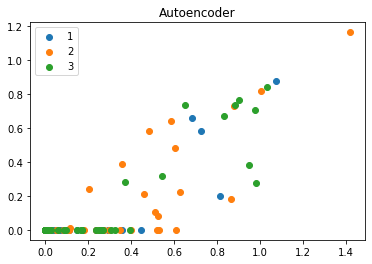

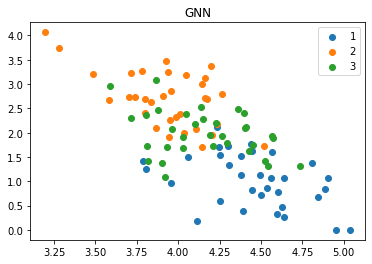

---------------- Delta = 7.75 -------------------


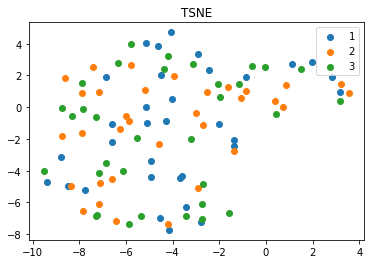

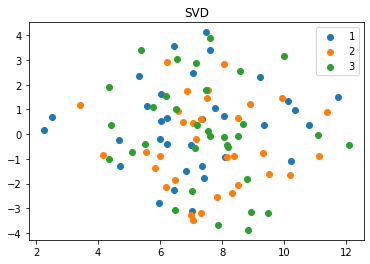

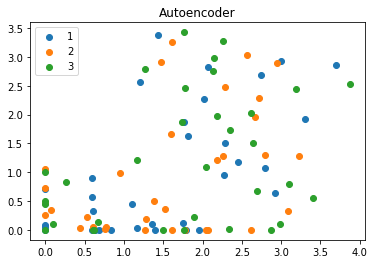

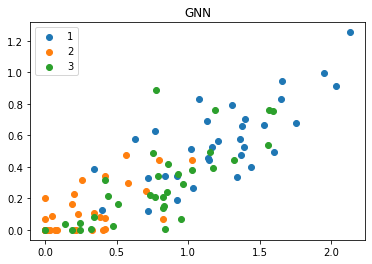

---------------- Delta = 10.0 -------------------


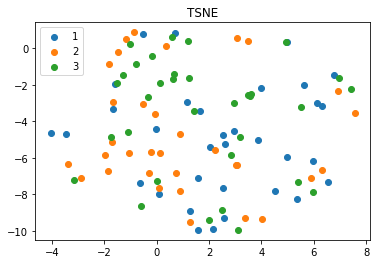

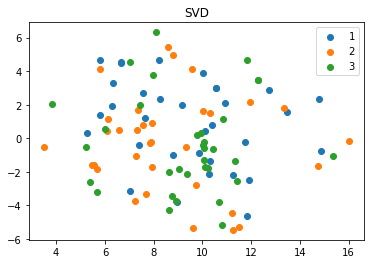

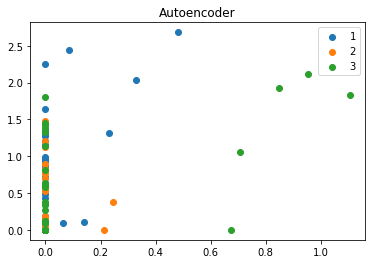

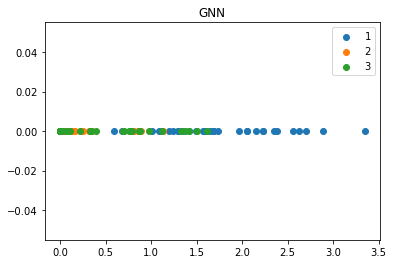

In [68]:
for delta in np.linspace(1,10,5):
    print(f"---------------- Delta = {delta} -------------------")
    X = make_vectors(basis,K,n,delta)
    X_t = TSNE().fit_transform(X)
    make_plot(X_t,"TSNE",delta)
    X_t = TruncatedSVD().fit_transform(X)
    make_plot(X_t,"SVD",delta)
    X_t = NN_embedding(X,Y)
    make_plot(X_t,"Autoencoder",delta)
    X_t = make_GNN_embedding(X,Y)
    make_plot(X_t,"GNN",delta)

In [69]:
P = np.zeros((3,3))

In [70]:
P

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [71]:
P[0,0] = 0.8
P[0,1] = 0.2
P[0,2] = 0.3
P[1,1] = 0.7
P[1,2] = 0.4
P[2,2] = 0.6
P = P + P.T - np.diag(P.diagonal())

In [72]:
k = 0
K = 3
n = 33

In [73]:
def make_basis(P,K):
    basis = []
    for i in range(K):
        basis.append([])
        for j in range(i,K):
            alpha = 0
            alpha = np.arccos(P[i,j])
            if i == j:## COLOCA OS DOIS VETORES PARA FORMAR A BASE
                v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                basis[-1].append([])
                basis[-1][-1].append(v)
                v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[-1][-1].append(v)
            else:## ESCOLHE ALEATORIAMENTE UM DOS VETORES
                u = np.random.uniform(0,1)
                v = np.zeros(2)
                if u > 0.5:
                    v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                else:
                    v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[-1].append(v)
    return basis

In [74]:
def make_vectors(basis,K,n,delta):
    X = np.zeros((3*n,2*K))
    for c in range(K):
        for i in range(n):
            for j in range(K):
                r = np.random.uniform(1,delta)
                if j<k:
                    X[i+n*c][2*j:2*j+2] = r*np.flip(basis[k][j])
                elif j==k:
                    u = np.random.uniform(0,1)
                    v = np.zeros(2)
                    if u > 0.5:
                        v = r*basis[k][j][1]
                    else:
                        v = r*basis[k][j][0]
                    X[i+n*c][2*j:2*j+2] = v
                else:
                    X[i+n*c][2*j:2*j+2] = r*basis[k][j]
    return X

In [75]:
basis = make_basis(P,K)
delta=2
X = make_vectors(basis,K,n,delta)

## Traditional Neural Networks Embedding

In [76]:
def get_Autoencoder(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2,activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(input_shape,activation='relu'))
#     model.summary()
    model.compile(optimizer=opt,loss='MSE')
    return model

In [77]:
def get_ANN(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2,activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3,activation='softmax'))
#     model.summary()
    model.compile(optimizer=opt,loss='CategoricalCrossentropy')
    return model

In [78]:
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
    name='NAdam'
)

In [79]:
def getExtractionModel(up_to=1,model=None):
    extractor = Sequential()
    for i in range(up_to):
        extractor.add(model.layers[i])
    return extractor

In [80]:
y = np.hstack([np.ones(n,dtype=np.int16)*i for i in range(K)])
Y = np.zeros((y.size, y.max()+1))
Y[np.arange(y.size),y] = 1

In [81]:
def NN_embedding(X,Y,autoencoder=False):
    model= None
    if autoencoder:
        model = get_Autoencoder((X.shape[1]))
        model.fit(X,X,epochs=100,shuffle=True,verbose=0)
    else:
        model = get_ANN((X.shape[1]))
        model.fit(X,Y,epochs=100,shuffle=True,verbose=0)
    encode = getExtractionModel(up_to=2,model=model)
#     print(encode.summary())
    X_t = np.array(encode.predict(X))
    return X_t

In [82]:
X.dtype

dtype('float64')

## Graph Neural Networks Embedding

In [83]:
def make_graph_data(X):
    G = nx.stochastic_block_model([n]*K,P,seed=42)
    for i in range(n*K):
        G.nodes[i]["attr"] = X[i,:]
    graph_data = from_networkx(G,group_node_attrs=['attr'])
    return graph_data

In [84]:
class GCN(torch.nn.Module):
    def __init__(self,n_feat):
        super().__init__()
        self.conv1 = GCNConv(n_feat, 2)
#         self.conv2 = GCNConv(16,2)
        self.mlp = torch.nn.Linear(2,K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
        x = self.mlp(x)
        return F.log_softmax(x, dim=1)

In [85]:
P

array([[0.8, 0.2, 0.3],
       [0.2, 0.7, 0.4],
       [0.3, 0.4, 0.6]])

In [86]:
def train_model(model,graph_data,Y,epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = total = 0
    graph_data.x = Tensor.float(graph_data.x)
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    target = Tensor(Y)
    while total < epochs:
        optimizer.zero_grad()
        out = model(graph_data)
        loss = loss_fn(out,target)
        loss.backward()
        optimizer.step()
        total += 1

In [87]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [88]:
def make_GNN_embedding(X,Y):
    graph_data = make_graph_data(X)
    model = GCN(graph_data.num_node_features)
    train_model(model,graph_data,Y)
    model.conv1.register_forward_hook(get_activation('conv1'))
    out = model(graph_data)
    X_t = F.relu(activation["conv1"]).detach().numpy()
    return X_t

In [89]:
def make_plot(X,title,delta):
    plt.scatter(X_t[:n,0],X_t[:n,1],label="1")
    plt.scatter(X_t[n:2*n,0],X_t[n:2*n,1],label="2")
    plt.scatter(X_t[2*n:3*n,0],X_t[2*n:3*n,1],label="3")
    plt.legend()
    plt.title(title)
    plt.savefig(title+f"_delta_{delta}.png")
    plt.show()

---------------- Delta = 1.0 -------------------


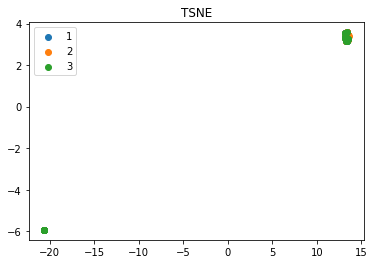

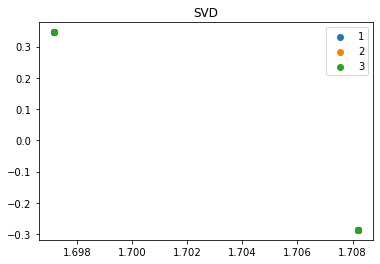

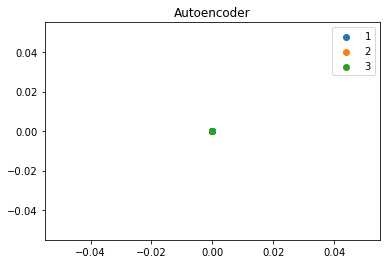

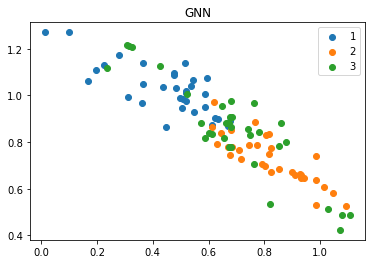

---------------- Delta = 25.75 -------------------


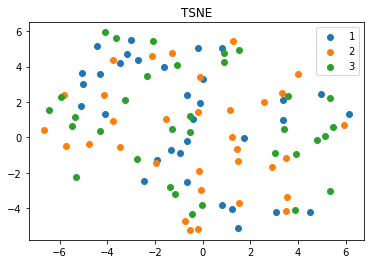

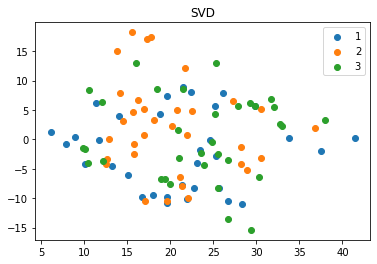

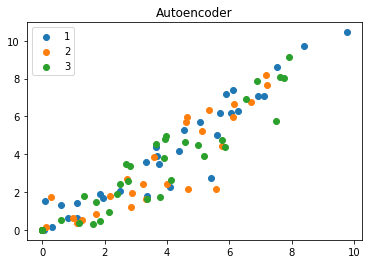

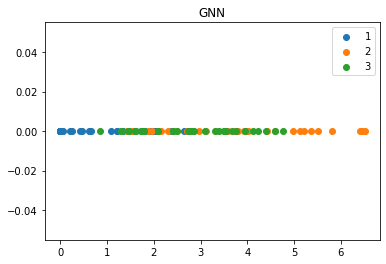

---------------- Delta = 50.5 -------------------


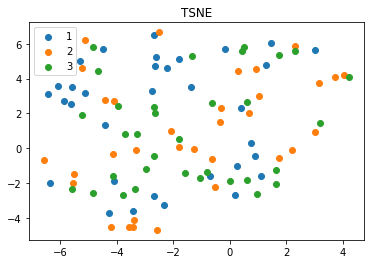

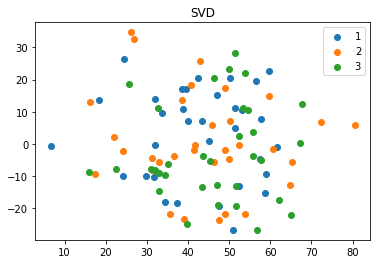

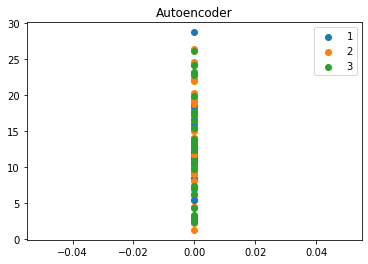

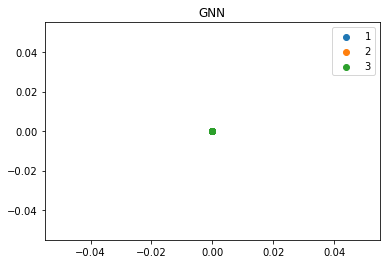

---------------- Delta = 75.25 -------------------


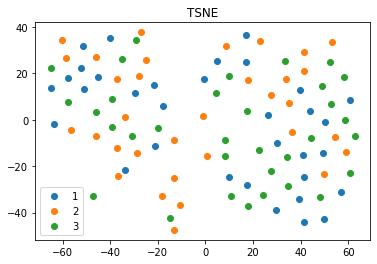

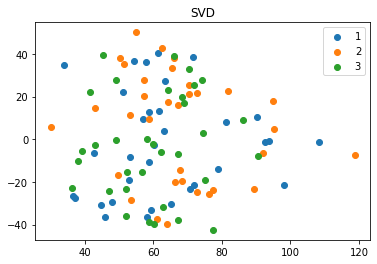

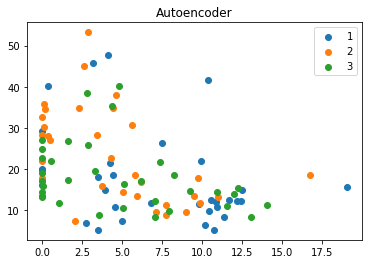

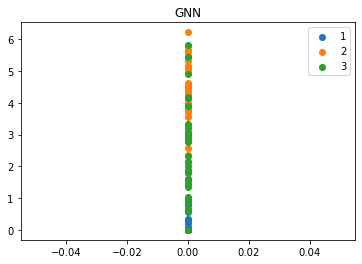

---------------- Delta = 100.0 -------------------


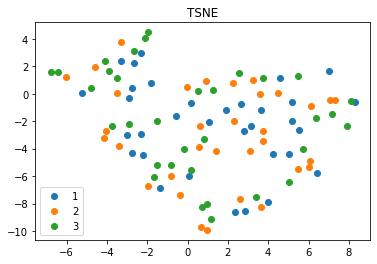

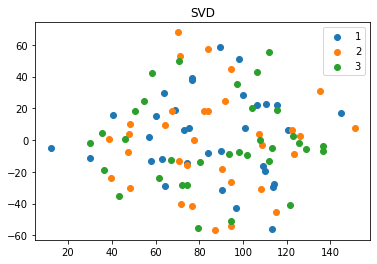

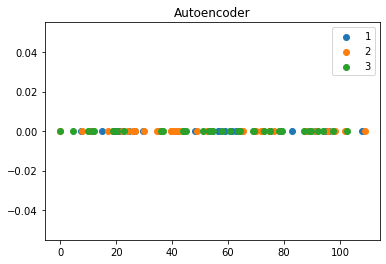

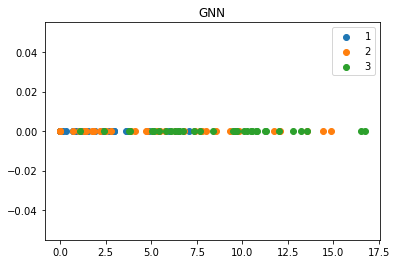

In [91]:
for delta in np.linspace(1,100,5):
    print(f"---------------- Delta = {delta} -------------------")
    X = make_vectors(basis,K,n,delta)
    X_t = TSNE().fit_transform(X)
    make_plot(X_t,"TSNE",delta)
    X_t = TruncatedSVD().fit_transform(X)
    make_plot(X_t,"SVD",delta)
    X_t = NN_embedding(X,Y,True)
    make_plot(X_t,"Autoencoder",delta)
    X_t = make_GNN_embedding(X,Y)
    make_plot(X_t,"GNN",delta)